This notebook shows doing air pollution modeling by using features from the transportation network instead of only calculate road density at the location of the groud monitor. 

Firstly install packages, with Kaggel you dont have to set the conda Environment.  This Python 3 environment comes with many helpful analytics libraries installed.
It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

 

In [215]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import read_csv
import os
import matplotlib.pyplot as plt


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import tensorflow as tf

import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

"""
Created on Tue Mar 17 16:19:38 2020

@author: menglu
"""




'\nCreated on Tue Mar 17 16:19:38 2020\n\n@author: menglu\n'

Load transportation network, they consists of 5 road types rasterized from OpenStreetMaps. 

In [216]:
road4 = np.load('../input/ap-road/road4.npy')
road3 = np.load('../input/ap-road/road3.npy')
road2 = np.load('../input/ap-road/road2.npy')
road5 = np.load('../input/ap-road/road5.npy')


road234=np.array(( road2,road3, road4, road5))
road234.shape
road234= np.where(road234 > 1, 1, 0) # convert to binary
 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


array([[[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

Reshape the 4-d array to observations, width, hight, channel (different road types)

In [217]:
road234r = np.moveaxis(road234, 3, 0)
road234r = np.moveaxis(road234r, 1, -1) # channel last: ! be super careful about what array reshape mean, it is not the same as movng axis!!
# road234r, Y = shuffle(road234r, Y) Why shuffle results in nan?
road234r.shape

(2630, 32, 32, 4)

* look at different roads of different road types 

In [218]:
np.max(road234r[1,:,:,3])

1

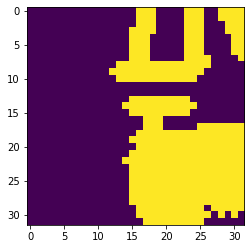

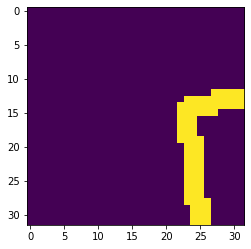

In [219]:
plt.imshow(road234r[1,:,:,3])
plt.show() 
plt.imshow(road234r[1,:,:,1])
plt.show() 
 

Load air pollution station measurements and split data into train+validation and test

In [220]:
mal = [599,2225,2478,2504] # id of removed rasters, remove also these values in the dataframe. 2630 stations in total
ap = read_csv('../input/station/airbase_oaq.csv')
print(ap.shape)
ap = ap[:-3042] #only first 2630 are used
ap = ap.drop(mal)
print(ap.shape)
ap.dropna # no na same as ap
ap['country'].unique()
Y = ap['value_mean'] # only use the station value

Xtrainv =road234r[1:2300,:,:,:] # 2300 for training and validation, consisting of trainging and validation
Xtest =road234r[2300:,:,:,:]  #330 for testing, not going to touch
Ytrainv = Y[1:2300]
Ytest = Y[2300:]

(5676, 5)
(2630, 5)


In [221]:
# define
# kernal initializer is important!
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape, kernel_initializer = 'normal'))
    model.add(layers.BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(32, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(1))
 
    model.add(Activation('relu'))
    return model
# I obtained higer accuracy with dropout and bachnorm. The mae is almost almost be around 10. 
# averagepooling is not as steady as maxpooling
# data augumentation assumes the inputs are images, with 1, 3, or 4 channels: grayscale, rgb, 
# the first dimension is always the number of samples. 

     
# "Loss"
   

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Model structure

K-fold crossvalidation

In [222]:
k  = 2 # fold
num_validation_samples = Xtrainv.shape[0]//k
validation_scores = []
for fold in range (k):
    validation_X= Xtrainv[num_validation_samples*fold : num_validation_samples*(fold+1),:,:,:]
    training_X = np.concatenate((Xtrainv[:num_validation_samples*fold,:,:,:] , Xtrainv[num_validation_samples*(fold+1):,:,:,:]),axis =0)
    validation_Y= Ytrainv[num_validation_samples*fold : num_validation_samples*(fold+1)]
    training_Y = np.concatenate((Ytrainv[:num_validation_samples*fold], Ytrainv[num_validation_samples*(fold+1):]),axis=None)     
    input_shape = (training_X.shape[1], training_X.shape[2], training_X.shape[3])        
    print (cnn_model().summary())
    m = cnn_model() 
    m.compile(loss='mae',
              optimizer='adam',
              metrics=['mse', 'mae'])
#compile only set up hyperparameters and error metrics, fit will do the training
    history = m.fit(training_X, training_Y,
          batch_size= 50,
          epochs= 10,
          verbose= 1,
          validation_data=(validation_X, validation_Y))
    validation_score =history.history['val_mae']
    validation_scores.append(validation_score)

validation_score =np.average(validation_scores)
testscore = m.evaluate(Xtest, Ytest, verbose=0)
print('val-:',validation_score, 'test:', testscore[0])
  

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        1184      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_60 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_61 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 15, 15, 32)      

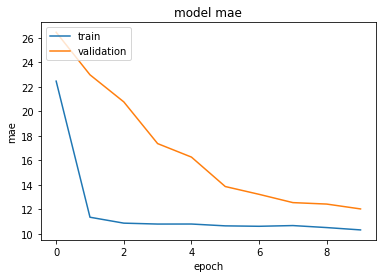

In [223]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# save before show(), otherwise wont work
plt.savefig("/kaggle/working/apcnn.png")
plt.show()

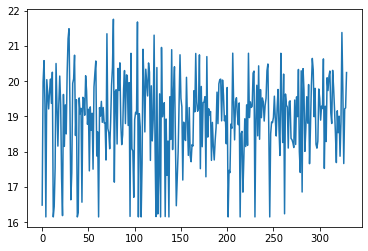

In [224]:
apmap = m.predict(Xtest)
plt.plot(apmap)

In [234]:
utroad2 = np.load('../input/utrechtroads/utroad2.npy')
utroad3 = np.load('../input/utrechtroads/utroad3.npy')
utroad4 = np.load('../input/utrechtroads/utroad4.npy')
utroad5 = np.load('../input/utrechtroads/utroad5.npy')
utroad234=np.array(( utroad2,utroad3, utroad4, utroad5))
utroad234.shape

utroad234r = np.moveaxis(utroad234, 2, 0)
utroad234r = np.moveaxis(utroad234r, 1, -1) # channel last
utroad234r.shape

utroad234r= np.where(utroad234r > 1, 1, 0)
 


In [241]:
np.median(utroad234r)

0.0

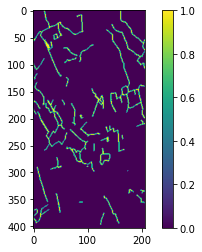

In [239]:
plt.imshow(utroad234r[:,:,3])
plt.colorbar()
 

In [176]:
utroad234r.shape
 

(403, 207, 4)

In [242]:
def slice(x, i, j):
    return x[i:(i+32),j:(j+32),:]

        

In [243]:
result = []
 
for i in range(0, (403-32)):
    for j in range(0, (207-32)):
        
        s = slice(utroad234r, i , j)
        result.append(s)
 
        
result = np.array(result)

In [244]:
Utrechtmap = m.predict(result)


In [245]:
apmap = Utrechtmap.reshape(371,175)


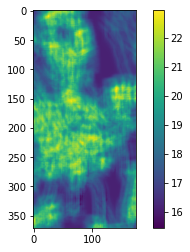

In [246]:


imgplot = plt.imshow(apmap)
plt.colorbar()

plt.savefig('/kaggle/working/utrechtmap.png')

In [247]:
apmap[1:3,1:10]

array([[16.813644, 16.853773, 16.839523, 16.919638, 17.1828  , 17.300005,
        17.523981, 17.630753, 17.890688],
       [16.824514, 16.89584 , 16.872742, 17.002829, 17.216997, 17.404913,
        17.563227, 17.765087, 17.91014 ]], dtype=float32)

In [248]:
plt.savefig('/kaggle/working/utrechtmap.png')
np.savetxt('/kaggle/working/apmap.csv', apmap, delimiter=',')

<Figure size 432x288 with 0 Axes>